In [1]:
import numpy as np
import illustris_python as il
import pandas as pd
import matplotlib
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from scipy import spatial
from tqdm import tqdm

import caesar
import readgadget
from readgadget import readsnap
import MAS_library as MASL
import smoothing_library as SL

In [2]:
TNG3snappath   = "/Volumes/Seagate/TNG300-3/output"
TNG3grouppath   = "/Volumes/Seagate/TNG300-1/output"
TNG3num=99

TNG1snappath   = "/Volumes/Seagate/TNG100-3/output"
TNG1grouppath   = "/Volumes/Seagate/TNG100-1/output"
TNG1num=99

ILLsnappath    = "/Volumes/Seagate/Illustris-3/output"
ILLgrouppath    = "/Volumes/Seagate/Illustris-1/output"
ILLnum=135

SIMBAsnappath  = "/Volumes/Seagate/Simba-Flag/output/snapdir_001/snap_m100n1024_151.hdf5"
SIMBAgrouppath  = "/Volumes/Seagate/Simba-Flag/output/groups_001/m100n1024_151.hdf5"
SIMBAnum= 0

In [11]:
def count_in_spheres(positions, centers, r=8.0, chunk_size=10_000_000):
    counts = np.zeros(len(centers), dtype=np.int64)
    r2 = r * r
    n_particles = positions.shape[0]

    # Iterate over chunks + progress bar
    for start in tqdm(range(0, n_particles, chunk_size), 
                      desc="Processing particles", 
                      unit="chunk"):
        end = min(start + chunk_size, n_particles)
        chunk = positions[start:end]

        # Loop over spheres
        for i, c in enumerate(centers):
            d2 = np.sum((chunk - c) ** 2, axis=1)
            counts[i] += np.count_nonzero(d2 < r2)

    return counts

In [12]:
temp_pos= np.array(readgadget.read_block(SIMBAsnappath, "POS ", [1])/1e3,dtype=np.float32)

In [15]:
temp_counts=count_in_spheres(temp_pos,temp_centers)

Processing particles: 100%|████████████████| 108/108 [56:59<00:00, 31.66s/chunk]


In [21]:
temp_stats=Stats(temp_counts)

In [25]:
print(int(temp_stats[0]))
print(int(temp_stats[1]))
print(int(temp_stats[2]))
print(temp_stats[3])
print(temp_stats[4])

2356426
2139880
145600
2356426.16±145600.40
3183053.730793955


In [18]:
print(temp_counts)

[ 2970553  3377856  1256473  1490197  3997102  1312659  1057032  2155959
  1280596  4087299   798655  3599478   790666  1571096  1960212  2201387
  2065885  2642800   998630   671743   985849  1343082  3539292  2402004
  2546319  1188122   936958  2342707  2432651  2393040 15223456 11353363
  6677931  1034389  1152201  5597128   805203  3155000  2802023   897548
   943105  1035090  2731541  3558063  1560112  1520767  1955148  1810374
  2063100  1676167  2047289  1487103  4174919   923172  1663629  1847559
   737006  1231130  2275479  1782488  6105460  1631724   588366  1631826
   799043  1548960  3103126  1715710  3873342  1464399   749087  1978528
  1216048  3166752  3328051   516015   637548   769632   437338  1919795
  1570854  1911750  1360095  3058872  1664549  1701580  5920368  3963217
  3017875  1063728  2729259  3475193  1251223  1847642  1123410  1517420
  2474585  5482971  3835435  1871557  2620822  1873700  3676612  2225590
  1608833   929398  1227019  1260893  1020644  7918

In [29]:
print(np.sum(temp_counts))
print(len(temp_pos))
print((len(temp_pos)-np.sum(temp_counts))/len(temp_pos))

508988050
1073741824
0.5259679388254881


In [13]:
temp_subhalos=caesar.load(SIMBAgrouppath)
temp_boxsize=np.float64(temp_subhalos.simulation.boxsize.to('Mpc/h')) # Mpc/h

yt : [INFO     ] 2025-09-25 14:03:18,417 Opening /Volumes/Seagate/Simba-Flag/output/groups_001/m100n1024_151.hdf5
yt : [INFO     ] 2025-09-25 14:03:18,547 Found 464043 halos
yt : [INFO     ] 2025-09-25 14:03:18,596 Found 55609 galaxies


In [14]:
temp_centers=Spheres(temp_boxsize)

In [ ]:
num_dm=[]
for i in range(1):
    dist= np.linalg.norm(temp_pos - temp_something[i], axis=1)
    mask= dist <= 8.0
    total_dm= np.sum(mask.astype(int))
    num_dm.append(total_dm)

In [3]:
def Weight_Density(size,lum,pos):
    size=int(size)
    # density field parameters
    grid    = 128                      #the 3D field will have grid x grid x grid voxels
    BoxSize = size                     #Mpc/h ; size of box
    MAS     = 'CIC'                    #mass-assigment scheme
    verbose = False                    #print information on progress
    L= lum                             #weight
    R = 4                              #smoothing kernal in Mpc/h
    Filter  = 'Top-Hat'                #type of smoothing kernal 
    threads = 8                        #computer threads, for parallelization
    
    # particle positions in 3D
    pos = pos
    
    # define 3D density field
    delta = np.zeros((grid,grid,grid), dtype=np.float32)
    
    # construct 3D density field
    MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose , W=L)
    
    # at this point, delta contains the effective number of particles in each voxel
    # now compute overdensity and density constrast
    delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

    # smooth the field
    W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
    delta_smoothed = SL.field_smoothing(delta, W_k, threads)

    return delta_smoothed

In [4]:
def Params(path, snappath,num):
    #Group parameters
    if "Simba" in path:
        snap_pos = np.array(readgadget.read_block(snappath, "POS ", [1])/1e3,dtype=np.float32) #positions in Mpc/h
        
        subhalos=caesar.load(path)
        subhalo_pos=np.array([i.pos.to('Mpc/h') for i in subhalos.galaxies],dtype=np.float32) # Mpc/h
        subhalo_mass=np.array([i.masses['total'].to('Msun/h') for i in subhalos.galaxies],dtype=np.float32) # Msun
        subhalo_lum=np.array([i.absmag['wfcam_k'] for i in subhalos.galaxies],dtype=np.float32)-1.87 #k_mag
        boxsize=np.float64(subhalos.simulation.boxsize.to('Mpc/h')) # Mpc/h
        
    else:
        snap=il.snapshot.loadSubset(snappath,num,'dm')
        snap_pos=np.array(snap['Coordinates'],dtype=np.float32)/1000 #Mpc/h
    
        fields = ["SubhaloPos","SubhaloMass","SubhaloStellarPhotometrics"]
        subhalos = il.groupcat.loadSubhalos(path,num,fields=fields)
        subhalo_pos = subhalos["SubhaloPos"]/1000   # Mpc/h
        subhalo_mass = subhalos["SubhaloMass"]*1e10 # Msun/h
        subhalo_lum = subhalos["SubhaloStellarPhotometrics"][:,3] #K_Mag
        header = il.groupcat.loadHeader(path,num)
        boxsize = header["BoxSize"]/1000 # Mpc/h

    #20 Mag cut
    cut = (subhalo_lum <= 20) & (subhalo_lum >= -20)
    subhalo_pos = subhalo_pos[cut]
    subhalo_mass = subhalo_mass[cut]
    subhalo_lum = subhalo_lum[cut]
    
    #Group average mass density
    volume = boxsize**3              # (Mpc/h)^3
    mass_tot = np.sum(subhalo_mass)  # Msun/h
    mass_avg = mass_tot/volume        # Msun/h / (Mpc/h)^3

    #Group average luminosity density
    lum=subhalo_lum
    vol=boxsize**3            #Volume of box sim (Mpc/h)^3 
    lum_avg=np.sum(lum)/vol   #Mag/(Mpc/h)^3 
    
    
    return subhalo_pos,subhalo_mass,mass_avg,boxsize,subhalo_lum,lum_avg,snap_pos

In [5]:
def Over_desnity(subhalo_pos,subhalo_mass,rho_avg,center):
    rho_over=[]
    for i in range(np.shape(center)[0]):
        #Select subhalos inside sphere
        dist = np.linalg.norm(subhalo_pos - center[i], axis=1)
        mask = dist <= 8.0
        m_total = subhalo_mass[mask].sum()

        #Compute density and over desnity
        volume = (4/3) * np.pi * 8**3       # (Mpc/h)^3
        rho = m_total / volume              # Msun/h / (Mpc/h)^3
        rho_sphere=(rho-rho_avg)/rho_avg    # No Units
        
        rho_over.append(rho_sphere)
    
    return np.array(rho_over)

In [6]:
def Spheres(boxsize):
    #Number of spheres that fit along one axis
    N = int(boxsize//16)
    coords = np.linspace(8, boxsize - 8, N)

    #Create 3d grid
    xv, yv, zv = np.meshgrid(coords, coords, coords, indexing="ij")
    centers = np.vstack([xv.ravel(), yv.ravel(), zv.ravel()]).T
    
    return centers

In [7]:
def Lum_Over_desnity(subhalo_pos,subhalo_lum,lum_avg,centers):
    #Over luminosity density (Does what the overdensity function does in Stats but now for over luminosities?

    rho_over=[]
    vol_sphere = (4/3) * np.pi * 8**3    #Volume of sphere (Mpc/h)^3 
    for i in range(np.shape(centers)[0]):
        #Select subhalos inside sphere (same as mass desnity)
        dist = np.linalg.norm(subhalo_pos - centers[i], axis=1)
        mask = dist <= 8.0
        lum_sphere = subhalo_lum[mask].sum()

        #Luminosity density of sphere and over luminosity density 
        rho=lum_sphere/vol_sphere   
        rho_sphere=(rho-lum_avg)/lum_avg
        
        rho_over.append(rho_sphere)
    rho_over=np.array(rho_over)
    
    return rho_over

In [8]:
def DM_Params(snap_pos,centers):
    #Select DM inside spheres (same as mass desnity)
    num_dm=[]
    for i in range(np.shape(centers)[0]):
        dist= np.linalg.norm(snap_pos - centers[i], axis=1)
        mask= dist <= 8.0
        total_dm= np.sum(mask.astype(int))
        num_dm.append(total_dm)

    return num_dm

In [9]:
def Stats(rho_over):
    #Statistics
    rho_mean=np.mean(rho_over)
    rho_std=np.std(rho_over)
    rho_err=rho_std/np.sqrt(int(np.shape(rho_over)[0]))
    rho_dis=f"{rho_mean:.2f}±{rho_err:.2f}"
    rms=np.sqrt(np.mean(rho_over**2))
    
    stats=[rho_mean,rho_std,rho_err,rho_dis,rms,rho_over]
    #0-mean, 1-standard devation, 2-error, 3-mean+\-error display, 4-root mean squared, 5-orgianl overdensity array
    return stats

In [10]:
def Overdensity(path, snappath, num):
    #Subhalo parameters
    subhalo_pos,subhalo_mass,mass_avg,boxsize,subhalo_lum,lum_avg,snap_pos=Params(path,snappath,num) 

    #Sphere centers equally spaced, non overlapping, and not outside sim
    centers=Spheres(boxsize)

    #Mass Overdesnity
    mass_over=Over_desnity(subhalo_pos,subhalo_mass,mass_avg,centers)
    mass_stats=Stats(mass_over)

    #Luminosity Overdesnity
    lum_over=Lum_Over_desnity(subhalo_pos,subhalo_lum,lum_avg,centers)
    lum_stats=Stats(lum_over)

    #Dark Matter
    dm_spheres=DM_Params(snap_pos,centers)
    
    return mass_stats,lum_stats,dm_spheres

In [12]:
sim_array={
    "name": ["SIMBA","TNG100","Illustrious","TNG300"],
    "grouppath": [SIMBAgrouppath,TNG1grouppath,ILLgrouppath,TNG3grouppath],
    "snappath": [SIMBAsnappath,TNG1snappath,ILLsnappath,TNG3snappath],
    "number": [SIMBAnum,TNG1num,ILLnum,TNG3num]
}
#0-Simba,1-TNG100,2-Illustrious,3-TNG300

lum_rms=[]
mass_rms=[]

In [ ]:
i=0
grouppath=sim_array["grouppath"][i]
snappath=sim_array["snappath"][i]
num=sim_array["number"][i]

mass_stats,lum_stats,dm_stats=Overdensity(grouppath,snappath,num)
lum_rms.append(lum_stats[4])
mass_rms.append(mass_stats[4])

yt : [INFO     ] 2025-09-25 09:02:42,481 Opening /Volumes/Seagate/Simba-Flag/output/groups_001/m100n1024_151.hdf5
yt : [INFO     ] 2025-09-25 09:02:42,854 Found 464043 halos
yt : [INFO     ] 2025-09-25 09:02:42,933 Found 55609 galaxies


In [ ]:
i=1
grouppath=sim_array["grouppath"][i]
snappath=sim_array["snappath"][i]
num=sim_array["number"][i]

mass_stats,lum_stats,dm_stats=Overdensity(grouppath,snappath,num)
lum_rms.append(lum_stats[4])
mass_rms.append(mass_stats[4])

In [ ]:
pandatime={
    "Simulation": sim_array["name"][:3],
    "Luminosity Overdesnity": lum_rms,
    "Mass Overdensity": mass_rms
}
display(pd.DataFrame(pandatime))

In [129]:
#This is runs both the luminosity count and then also the mass over desity to compare (does not currently support simba)
# sim_array=[["SIMBA",SIMBAgrouppath,0],
#           ["TNG100",TNG1grouppath,TNG1num],
#           ["Illustrious",ILLgrouppath,ILLnum],
#           ["TNG300",TNG3grouppath,TNG3num]] #name,path,num
sim_array=[["SIMBA",SIMBAgrouppath,0],["TNG100",TNG1grouppath,TNG1num],["Illustrious",ILLgrouppath,ILLnum],["TNG300",TNG3grouppath,TNG3num]] #name,path,num

name_display=[]
rho_display=[]
rms_display=[]
rho_over_display=[]
rho_mean=[]
rho_err=[]
for i in sim_array:
    name_display.append(i[0])
    temp_stats=LumStats(i[1],i[2]) #0 Mean,1 Standard Devation,2 Standard Error,3 Mean+/-Error,4 Root Mean Square,5 Over density
    rho_mean.append(temp_stats[0])
    rho_err.append(temp_stats[2])
    rho_display.append(temp_stats[3])
    rms_display.append(temp_stats[4])
    rho_over_display.append(temp_stats[5])
    
for i in sim_array:
    name_display.append(i[0])
    temp_stats=Stats(i[1],i[2]) #0 Mean,1 Standard Devation,2 Standard Error,3 Mean+/-Error,4 Root Mean Square,5 Over density
    rho_mean.append(temp_stats[0])
    rho_err.append(temp_stats[2])
    rho_display.append(temp_stats[3])
    rms_display.append(temp_stats[4])
    rho_over_display.append(temp_stats[5])

yt : [INFO     ] 2025-09-04 16:01:53,808 Opening /Volumes/Seagate/Simba-Flag/output/groups_001/m100n1024_151.hdf5
yt : [INFO     ] 2025-09-04 16:01:53,857 Found 464043 halos
yt : [INFO     ] 2025-09-04 16:01:53,920 Found 55609 galaxies
yt : [INFO     ] 2025-09-04 16:02:53,941 Opening /Volumes/Seagate/Simba-Flag/output/groups_001/m100n1024_151.hdf5
yt : [INFO     ] 2025-09-04 16:02:53,992 Found 464043 halos
yt : [INFO     ] 2025-09-04 16:02:54,045 Found 55609 galaxies


In [9]:
#This is just to run the Mass overdensity 
sim_array=[["SIMBA",SIMBAgrouppath,0],
          ["TNG100",TNG1grouppath,TNG1num],
          ["Illustrious",ILLgrouppath,ILLnum],
          ["TNG300",TNG3grouppath,TNG3num]] #name,path,num

name_display=[]
rho_display=[]
rms_display=[]
rho_over_display=[]
rho_mean=[]
rho_err=[]
for i in sim_array:
    name_display.append(i[0])
    temp_stats=Stats(i[1],i[2]) #0 Mean,1 Standard Devation,2 Standard Error,3 Mean+/-Error,4 Root Mean Square,5 Over density
    rho_mean.append(temp_stats[0])
    rho_err.append(temp_stats[2])
    rho_display.append(temp_stats[3])
    rms_display.append(temp_stats[4])
    rho_over_display.append(temp_stats[5])

yt : [INFO     ] 2025-09-04 12:36:39,376 Opening /Volumes/Seagate/Simba-Flag/output/groups_001/m100n1024_151.hdf5
yt : [INFO     ] 2025-09-04 12:36:39,439 Found 464043 halos
yt : [INFO     ] 2025-09-04 12:36:39,507 Found 55609 galaxies


NameError: name 'suubhalos' is not defined

In [130]:
#Rows for DF and displays
rows=[]
for i in range(len(name_display)):
    rows.append({"Simulation":name_display[i], "Over Density Mean":rho_display[i], "RMS":rms_display[i]})
displaydf=pd.DataFrame(rows)
display(displaydf)

,Simulation,Over Density Mean,RMS
0,SIMBA,0.03±0.09,1.343175
1,TNG100,-0.04±0.09,0.756349
2,Illustrious,-0.04±0.09,0.741693
3,TNG300,0.00±0.02,0.879767
4,SIMBA,0.02±0.06,0.839465
5,TNG100,-0.03±0.06,0.511152
6,Illustrious,-0.03±0.06,0.512049
7,TNG300,0.00±0.01,0.610220


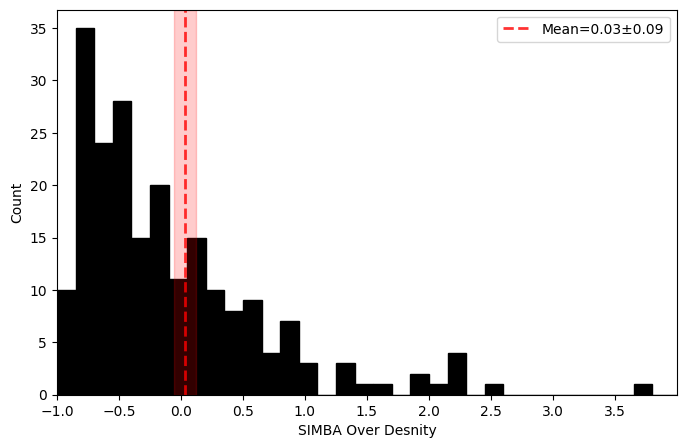

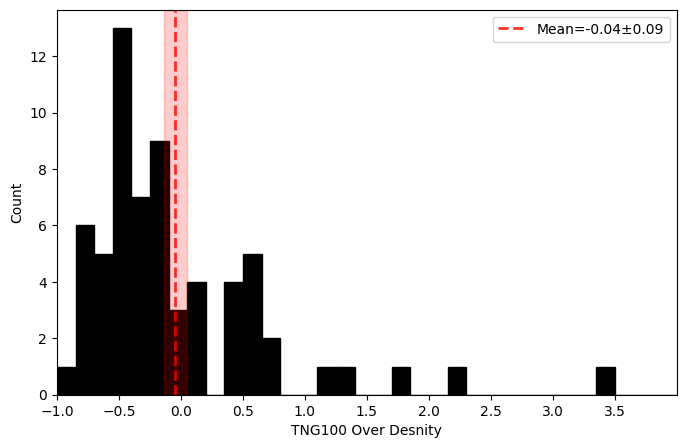

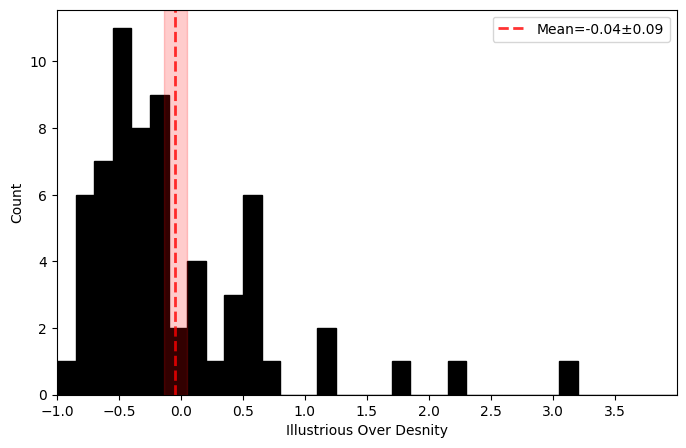

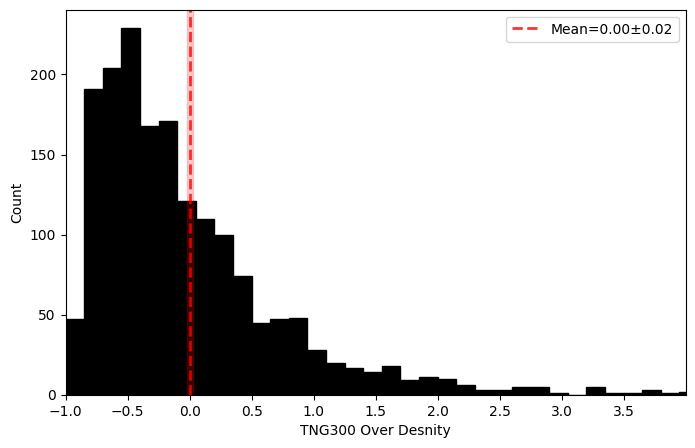

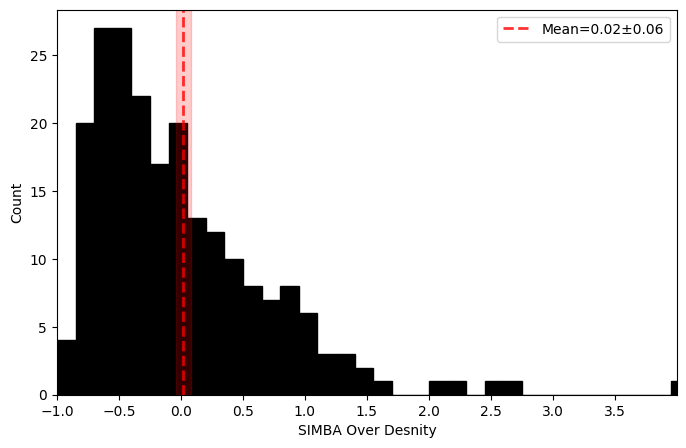

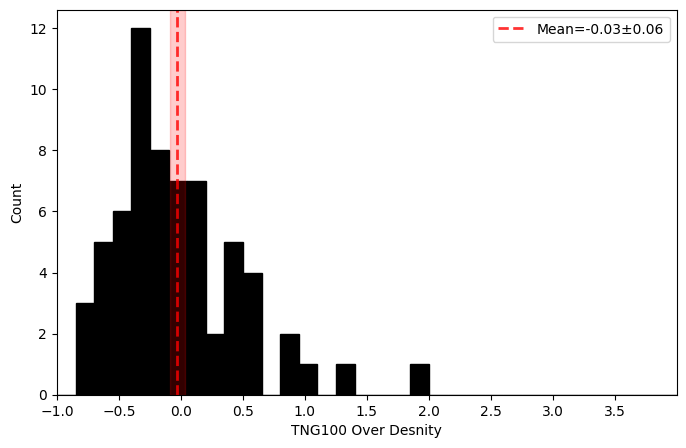

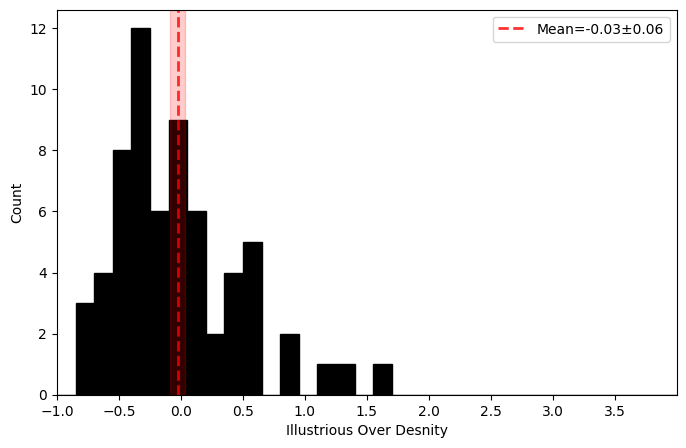

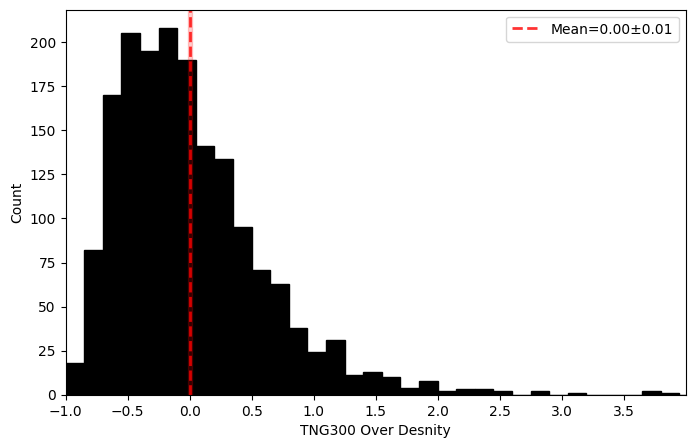

In [132]:
#Range and Bins
x_min = -1
x_max = 4

bin_width = 0.15
bins = np.arange(x_min, x_max + bin_width, bin_width)

for i in range(len(rho_over_display)):
    #Plot histogram
    plt.figure(figsize=(8,5))
    
    #Data
    plt.hist(rho_over_display[i], bins=bins, color="black", edgecolor='black', alpha=1)

    #Mean line
    plt.axvline(rho_mean[i], color='red', linestyle='--', linewidth=2, alpha=0.8, label="Mean="+rho_display[i])

    #Standard error shaded region
    plt.axvspan(rho_mean[i] - rho_err[i], rho_mean[i] + rho_err[i], color='red', alpha=0.2)

    #Labels and title
    plt.xlabel(name_display[i]+" Over Desnity")
    plt.ylabel("Count")
    plt.xticks(np.arange(x_min, x_max, .5))
    plt.xlim(x_min, x_max)
    plt.legend()

    plt.show()